<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#General-imports" data-toc-modified-id="General-imports-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>General imports</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#Characterise-connectivity-matrix-response-to-homogeneous-training-protocol" data-toc-modified-id="Characterise-connectivity-matrix-response-to-homogeneous-training-protocol-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Characterise connectivity matrix response to homogeneous training protocol</a></span><ul class="toc-item"><li><span><a href="#An-example" data-toc-modified-id="An-example-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>An example</a></span></li><li><span><a href="#Plots-of-overall-variation" data-toc-modified-id="Plots-of-overall-variation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Plots of overall variation</a></span><ul class="toc-item"><li><span><a href="#Simple-example-to-play-with" data-toc-modified-id="Simple-example-to-play-with-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Simple example to play with</a></span></li><li><span><a href="#Training-time-variation" data-toc-modified-id="Training-time-variation-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Training time variation</a></span></li><li><span><a href="#tau_z-variation" data-toc-modified-id="tau_z-variation-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>tau_z variation</a></span></li><li><span><a href="#IPI-variation" data-toc-modified-id="IPI-variation-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>IPI variation</a></span></li></ul></li><li><span><a href="#Ratios-variation" data-toc-modified-id="Ratios-variation-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Ratios variation</a></span><ul class="toc-item"><li><span><a href="#Training-time" data-toc-modified-id="Training-time-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Training time</a></span></li><li><span><a href="#Tau_z" data-toc-modified-id="Tau_z-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Tau_z</a></span></li><li><span><a href="#Inter-Pulse-Interval" data-toc-modified-id="Inter-Pulse-Interval-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Inter-Pulse-Interval</a></span></li></ul></li><li><span><a href="#Is-alpha-constant" data-toc-modified-id="Is-alpha-constant-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Is alpha constant</a></span><ul class="toc-item"><li><span><a href="#An-example" data-toc-modified-id="An-example-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>An example</a></span></li></ul></li></ul></li></ul></div>

# Preamble

## General imports

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=2.5)

from network import Protocol, NetworkManager, Network
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

epsilon = 10e-80
vmin = -10.0

## Functions

In [2]:
def get_weights_structure(training_time, inter_pulse_interval, tau_z_pre, 
                          tau_z_post, include_first=False):
    
    strict_maximum = True

    g_a = 1.0
    g_I = 10.0
    tau_a = 0.250
    G = 1.0
    sigma_out = 0.0
    tau_s = 0.010
    tau_z_pre = tau_z_pre
    tau_z_post = tau_z_post

    hypercolumns = 1
    minicolumns = 20
    n_patterns = minicolumns

    # Training protocol
    training_times = [training_time for i in range(n_patterns)]
    inter_pulse_intervals = [inter_pulse_interval for i in range(n_patterns)]
    inter_sequence_interval = 0.0
    resting_time = 2.5
    epochs = 1

    # Manager properties
    dt = 0.0001
    values_to_save = ['o']

    from_index = 10
    to_index = 11

    # Neural Network
    nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    # Build the representation
    representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                            minicolumns=minicolumns)

    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals, inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)
    
    ws = nn.w[from_index, from_index]
    wn = nn.w[to_index, from_index]
    wb = nn.w[from_index - 1, from_index]
    wr = nn.w[to_index + 1, from_index]
    alphas = [nn.w[1 + i, 0] - nn.w[2 + i, 0] for i in range(4)]
    
    if include_first:
        range_rests = list(range(to_index, minicolumns))
        w_rests = nn.w[to_index:, from_index]
        range_backs = list(range(0, to_index - 1))
        w_backs = nn.w[:(to_index - 1), from_index]
    else:
        range_rests = list(range(to_index + 1, minicolumns))
        w_rests = nn.w[(to_index + 1):, from_index]
        range_backs = list(range(0, to_index - 2))
        w_backs = nn.w[:(to_index - 2), from_index]

    results_dictionary = {}
    results_dictionary['ws'] = ws
    results_dictionary['wn'] = wn
    results_dictionary['wb'] = wb
    results_dictionary['wr'] = wr
    results_dictionary['w_rests'] = w_rests
    results_dictionary['range rests'] = range_rests
    results_dictionary['w_backs'] = w_backs
    results_dictionary['range backs'] = range_backs
    results_dictionary['w'] = nn.w[:, from_index]
    results_dictionary['diff_next'] = ws - wn
    results_dictionary['diff_rest'] = wn - wr
    results_dictionary['r'] = (wn - wr) / (ws - wn)
    results_dictionary['alphas'] = alphas    
    
    return results_dictionary 

# Characterise connectivity matrix response to homogeneous training protocol

## An example

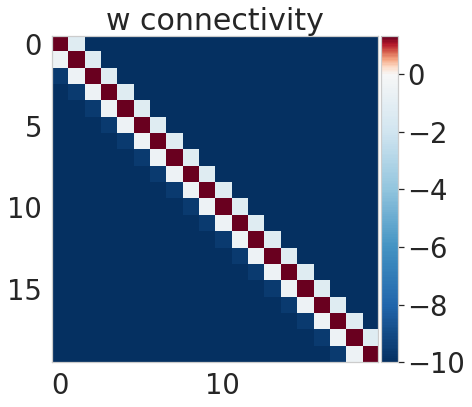

In [18]:
strict_maximum = True

g_a = 1.0
g_I = 10.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.015

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
training_times = 0.500
training_times = [training_times for i in range(n_patterns)]
inter_pulse_intervals = [0.020 for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1

# Manager properties
dt = 0.0001
values_to_save = ['o']

from_index = 10
to_index = 11

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
             tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
             strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                        minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals, inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)

plot_weight_matrix(manager, vmin=vmin)

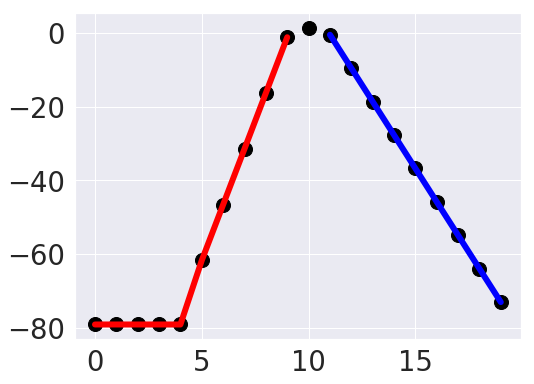

In [19]:
include_first = True
ws = nn.w[from_index, from_index]
wn = nn.w[to_index, from_index]
wb = nn.w[from_index - 1, from_index]
if include_first:
    range_rests = list(range(to_index, minicolumns))
    w_rests = nn.w[to_index:, from_index]
    range_backs = list(range(0, to_index - 1))
    w_backs = nn.w[:(to_index - 1), from_index]
else:
    range_rests = list(range(to_index + 1, minicolumns))
    w_rests = nn.w[(to_index + 1):, from_index]
    range_backs = list(range(0, to_index - 2))
    w_backs = nn.w[:(to_index - 2), from_index]

lw = 6
ms = 14

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(nn.w[:, from_index], 'o', ms=ms, color='black')
ax.plot(range_rests, w_rests, ls='-', lw=lw, color='blue')
ax.plot(range_backs, w_backs, ls='-', lw=lw, color='red');

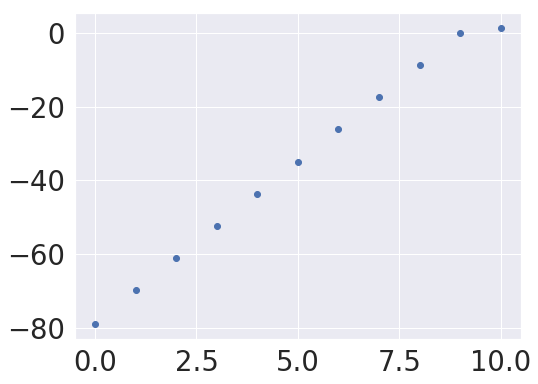

In [17]:
plt.plot(nn.w[10, :11], 'o')

## Plots of overall variation

### Simple example to play with

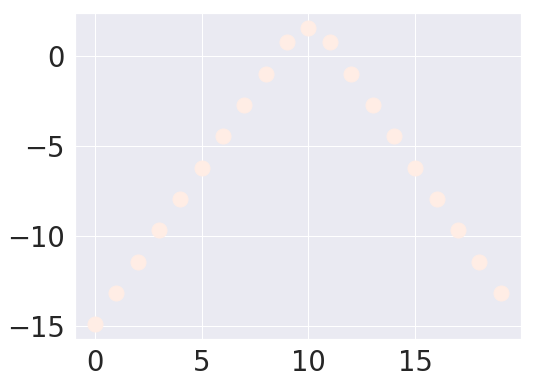

In [5]:
num = 20
lw = 8
ms = 15
colors = sns.color_palette("Reds", num)
fig = plt.figure()
ax = fig.add_subplot(111)

training_time = 0.100
inter_pulse_interval = 0
tau_z_pre = 0.025
tau_z_post = 0.025
results_dictionary = get_weights_structure(training_time, inter_pulse_interval, tau_z_pre, 
                                           tau_z_post, include_first=False)
index = 0
w = results_dictionary['w']
ax.plot(w, 'o', color=colors[index], ms=ms, lw=lw);

### Training time variation

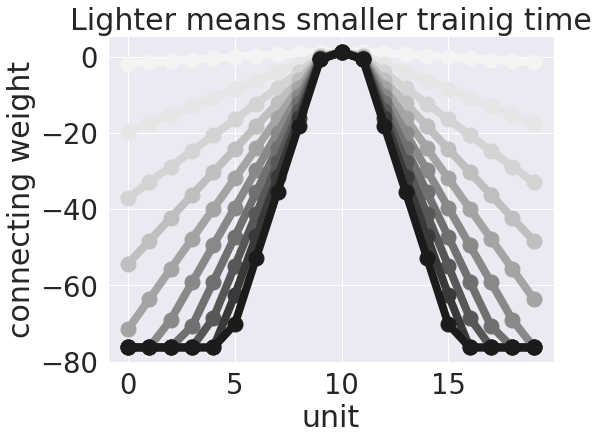

In [6]:
num = 10
lw = 8
ms = 15
colors = sns.color_palette("Greys", num)
fig = plt.figure()
ax = fig.add_subplot(111)

inter_pulse_interval = 0
tau_z_pre = 0.025
tau_z_post = 0.025

training_times_vector = np.linspace(0.020, 1.0, num=num)
for index, training_time in enumerate(training_times_vector):
    results_dictionary = get_weights_structure(training_time, inter_pulse_interval, tau_z_pre, 
                                               tau_z_post, include_first=False)
    w = results_dictionary['w']
    ax.plot(w, 'o-', color=colors[index], ms=ms, lw=lw)
    ax.set_title('Lighter means smaller trainig time')
    ax.set_xlabel('unit')
    ax.set_ylabel('connecting weight')

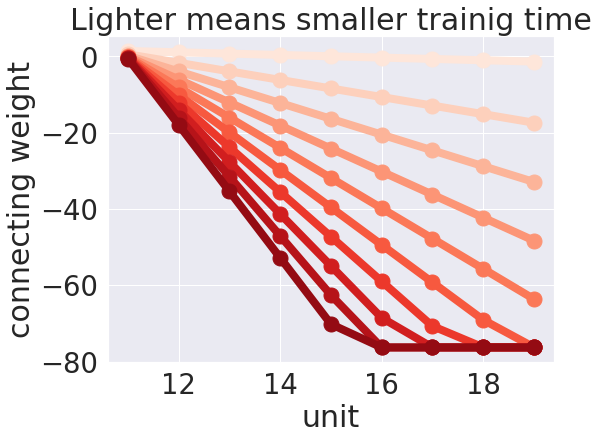

In [7]:
lw = 8
ms = 15
colors = sns.color_palette("Reds", num)
fig = plt.figure()
ax = fig.add_subplot(111)


for index, training_time in enumerate(training_times_vector):
    results_dictionary = get_weights_structure(training_time, inter_pulse_interval, tau_z_pre, 
                                               tau_z_post, include_first=True)
    w_rests = results_dictionary['w_rests']
    range_rests = results_dictionary['range rests']
    ax.plot(range_rests, w_rests, 'o-', color=colors[index], ms=ms, lw=lw)
    ax.set_title('Lighter means smaller trainig time')
    ax.set_xlabel('unit')
    ax.set_ylabel('connecting weight')

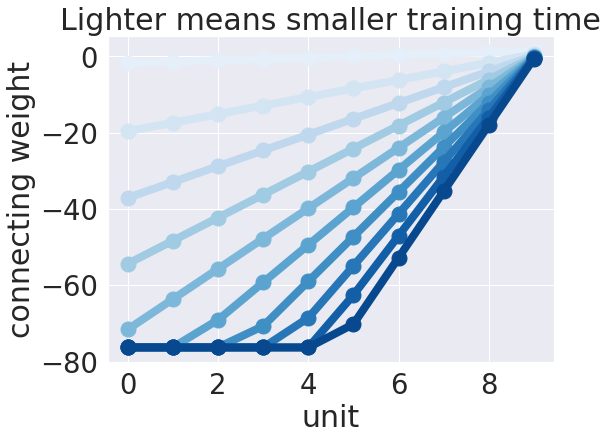

In [8]:
lw = 8
ms = 15
colors = sns.color_palette("Blues", num)
fig = plt.figure()
ax = fig.add_subplot(111)


for index, training_time in enumerate(training_times_vector):
    results_dictionary = get_weights_structure(training_time, inter_pulse_interval, tau_z_pre, 
                                               tau_z_post, include_first=True)
    w_backs = results_dictionary['w_backs']
    range_backs = results_dictionary['range backs']
    ax.plot(range_backs, w_backs, 'o-', color=colors[index], ms=ms, lw=lw)
    ax.set_title('Lighter means smaller training time')
    ax.set_xlabel('unit')
    ax.set_ylabel('connecting weight')

### tau_z variation

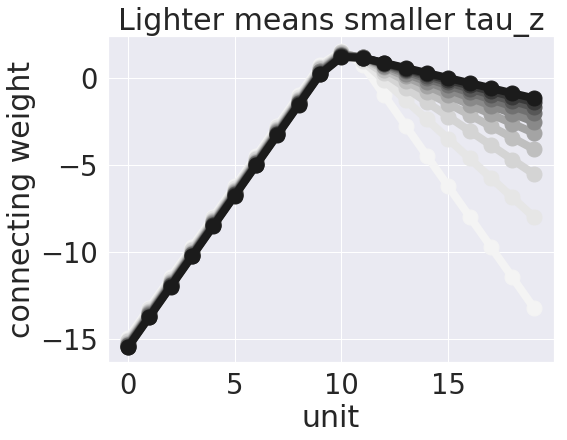

In [9]:
num = 10
lw = 8
ms = 15
colors = sns.color_palette("Greys", num)
fig = plt.figure()
ax = fig.add_subplot(111)

training_time = 0.100
inter_pulse_interval = 0
tau_z_pre = 0.025
tau_z_post = 0.025

tau_z_vector = np.linspace(0.025, 0.150, num=num)
for index, tau_z_pre in enumerate(tau_z_vector):
    results_dictionary = get_weights_structure(training_time, inter_pulse_interval, tau_z_pre, 
                                               tau_z_post, include_first=True)
    w = results_dictionary['w']
    range_rests = results_dictionary['range rests']
    ax.plot(w, 'o-', color=colors[index], ms=ms, lw=lw)
    ax.set_title('Lighter means smaller tau_z')
    ax.set_xlabel('unit')
    ax.set_ylabel('connecting weight')

### IPI variation

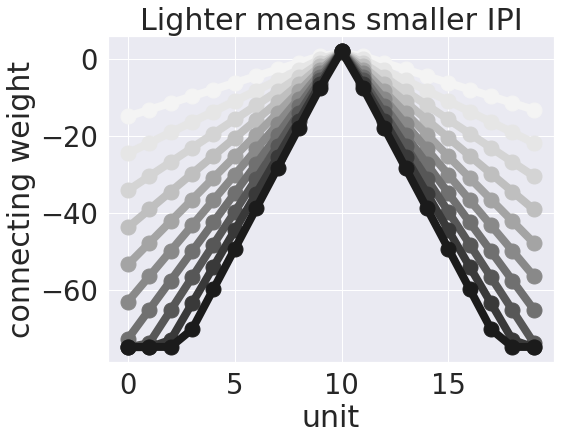

In [10]:
num = 10
lw = 8
ms = 15
colors = sns.color_palette("Greys", num)
fig = plt.figure()
ax = fig.add_subplot(111)

training_time = 0.100
inter_pulse_interval = 0
tau_z_pre = 0.025
tau_z_post = 0.025

inter_pulse_interval_vector = np.linspace(0.000, 0.50, num=num)
for index, inter_pulse_interval in enumerate(inter_pulse_interval_vector):
    results_dictionary = get_weights_structure(training_time, inter_pulse_interval, tau_z_pre, 
                                               tau_z_post, include_first=True)
    w = results_dictionary['w']
    range_rests = results_dictionary['range rests']
    ax.plot(w, 'o-', color=colors[index], ms=ms, lw=lw)
    ax.set_title('Lighter means smaller IPI')
    ax.set_xlabel('unit')
    ax.set_ylabel('connecting weight')

## Ratios variation 

### Training time

In [11]:
%%time
num = 20
lw = 8
ms = 15
colors = sns.color_palette("Greys", num)

training_time = 0.100
inter_pulse_interval = 0
tau_z_pre = 0.025
tau_z_post = 0.005

training_times_vector = np.linspace(0.020, 1.500, num=num)
ratios = np.zeros(num)
diff_next = np.zeros(num)
diff_rest = np.zeros(num)
mean_alpha_differences = np.zeros(num)

for index, training_time in enumerate(training_times_vector):
    results_dictionary = get_weights_structure(training_time, inter_pulse_interval, tau_z_pre, 
                                               tau_z_post, include_first=False)
    ratios[index] = results_dictionary['r']
    diff_next[index] = results_dictionary['diff_next']
    diff_rest[index] = results_dictionary['diff_rest']
    alphas = results_dictionary['alphas']
    mean_alpha_differences[index] = np.mean(np.diff(alphas))

CPU times: user 3min 3s, sys: 30.5 s, total: 3min 33s
Wall time: 1min 44s


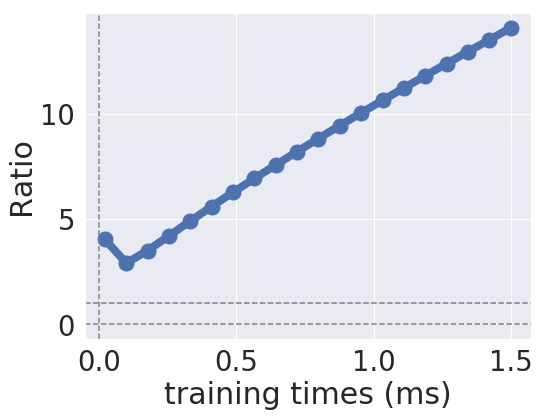

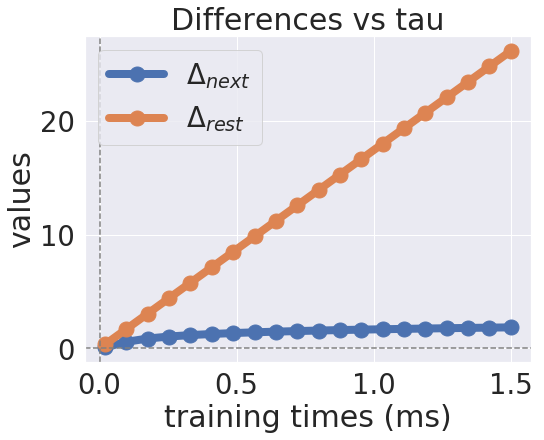

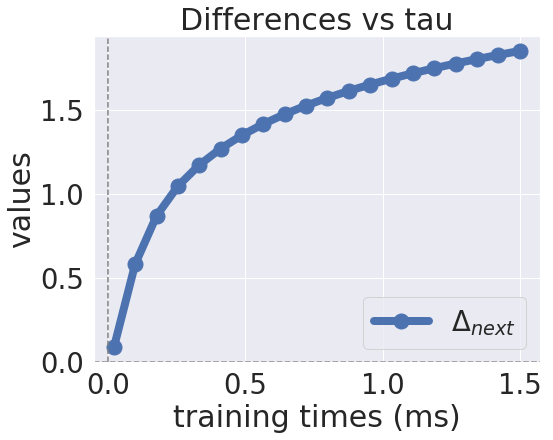

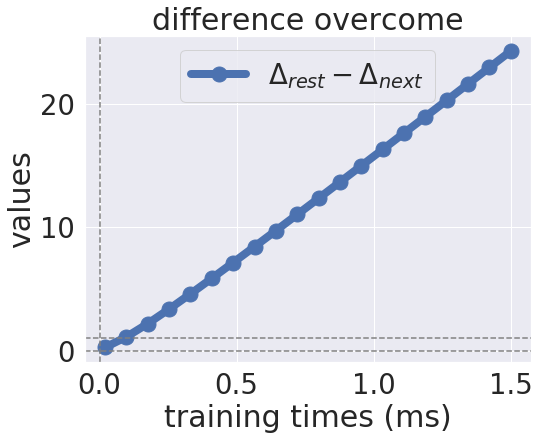

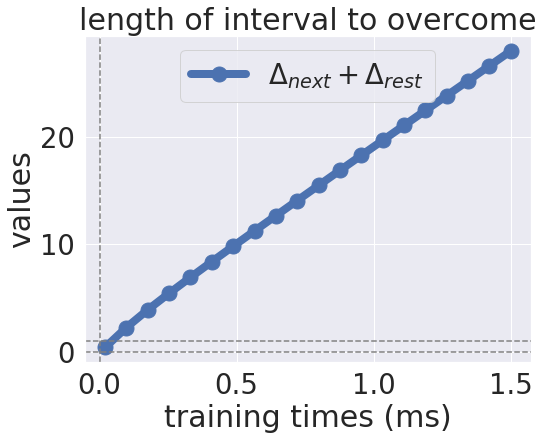

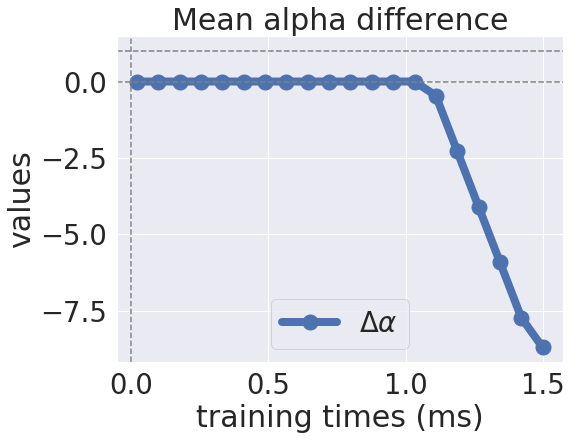

In [12]:
independent = training_times_vector
xlabel = r'training times (ms)'

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(independent, ratios, 'o-', ms=ms, lw=lw)
ax.set_xlabel(xlabel)
ax.set_ylabel('Ratio')

ax.axhline(1, ls='--', color='gray')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray');

fig = plt.figure()
ax = fig.add_subplot(111)    

ax.plot(independent, diff_next, 'o-', ms=ms, lw=lw, label=r'$\Delta_{next}$')
ax.plot(independent, diff_rest, 'o-', ms=ms, lw=lw, label=r'$\Delta_{rest}$')
ax.set_title('Differences vs tau')
ax.set_xlabel(xlabel)
ax.set_ylabel('values')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

fig = plt.figure()
ax = fig.add_subplot(111)    

ax.plot(independent, diff_next, 'o-', ms=ms, lw=lw, label=r'$\Delta_{next}$')
ax.set_title('Differences vs tau')
ax.set_xlabel(xlabel)
ax.set_ylabel('values')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

fig = plt.figure()
ax = fig.add_subplot(111)    

ax.plot(independent, diff_rest - diff_next, 'o-', ms=ms, lw=lw, label=r'$\Delta_{rest} - \Delta_{next}$ ')
ax.set_title('difference overcome')
ax.set_xlabel(xlabel)
ax.set_ylabel('values')

ax.axhline(1.0, ls='--', color='gray')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

fig = plt.figure()
ax = fig.add_subplot(111)   
ax.plot(independent, diff_next + diff_rest, 'o-', ms=ms, lw=lw, label=r'$\Delta_{next} + \Delta_{rest}$ ')
ax.set_title('length of interval to overcome')
ax.set_xlabel(xlabel)
ax.set_ylabel('values')

ax.axhline(1.0, ls='--', color='gray')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend()

fig = plt.figure()
ax = fig.add_subplot(111)    

ax.plot(independent, mean_alpha_differences, 'o-', ms=ms, lw=lw, label=r'$\Delta \alpha$')
ax.set_title('Mean alpha difference')
ax.set_xlabel(xlabel)
ax.set_ylabel('values')

ax.axhline(1.0, ls='--', color='gray')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

### Tau_z

In [13]:
%%time
num = 30
lw = 8
ms = 15
colors = sns.color_palette("Greys", num)

training_time = 0.100
inter_pulse_interval = 0
tau_z_pre = 0.025
tau_z_post = 0.025

tau_z_vector = np.linspace(0.005, 0.150, num=num)
ratios = np.zeros(num)
diff_next = np.zeros(num)
diff_rest = np.zeros(num)
mean_alpha_differences = np.zeros(num)


for index, tau_z_pre in enumerate(tau_z_vector):
    results_dictionary = get_weights_structure(training_time, inter_pulse_interval, tau_z_pre, 
                                               tau_z_post, include_first=False)
    ratios[index] = results_dictionary['r']
    diff_next[index] = results_dictionary['diff_next']
    diff_rest[index] = results_dictionary['diff_rest']
    alphas = results_dictionary['alphas']
    mean_alpha_differences[index] = np.mean(np.diff(alphas))

CPU times: user 1min 24s, sys: 13 s, total: 1min 37s
Wall time: 39.7 s


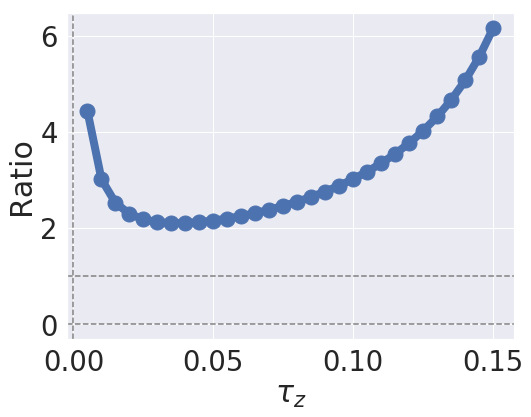

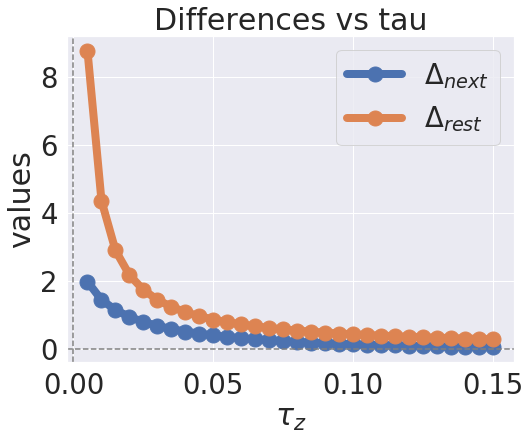

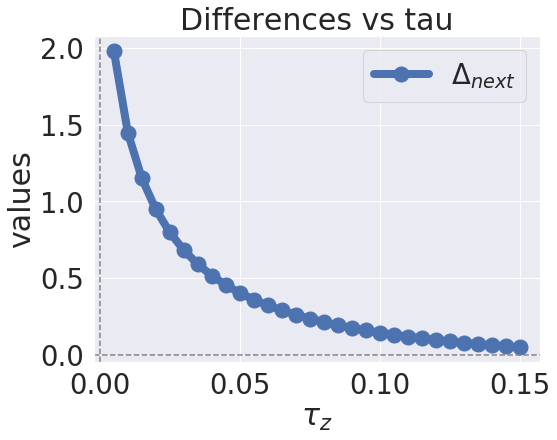

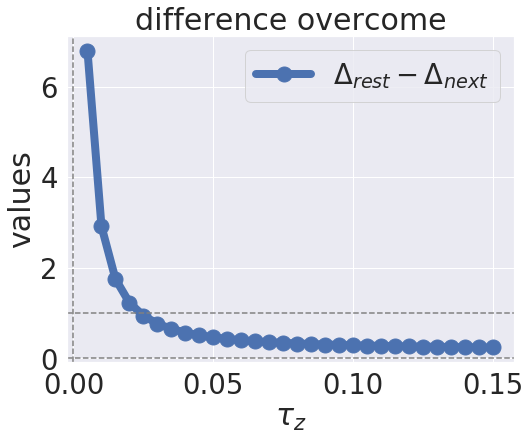

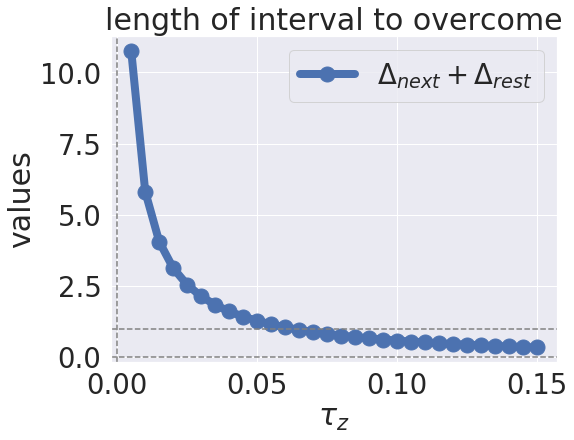

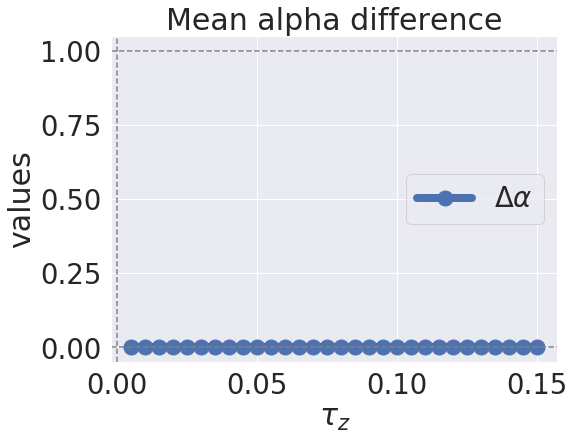

In [14]:
independent = tau_z_vector
xlabel = r'$\tau_z$'

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(independent, ratios, 'o-', ms=ms, lw=lw)
ax.set_xlabel(xlabel)
ax.set_ylabel('Ratio')

ax.axhline(1, ls='--', color='gray')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray');

fig = plt.figure()
ax = fig.add_subplot(111)    

ax.plot(independent, diff_next, 'o-', ms=ms, lw=lw, label=r'$\Delta_{next}$')
ax.plot(independent, diff_rest, 'o-', ms=ms, lw=lw, label=r'$\Delta_{rest}$')
ax.set_title('Differences vs tau')
ax.set_xlabel(xlabel)
ax.set_ylabel('values')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

fig = plt.figure()
ax = fig.add_subplot(111)    

ax.plot(independent, diff_next, 'o-', ms=ms, lw=lw, label=r'$\Delta_{next}$')
ax.set_title('Differences vs tau')
ax.set_xlabel(xlabel)
ax.set_ylabel('values')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

fig = plt.figure()
ax = fig.add_subplot(111)    

ax.plot(independent, diff_rest - diff_next, 'o-', ms=ms, lw=lw, label=r'$\Delta_{rest} - \Delta_{next}$')
ax.set_title('difference overcome')
ax.set_xlabel(xlabel)
ax.set_ylabel('values')

ax.axhline(1.0, ls='--', color='gray')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

fig = plt.figure()
ax = fig.add_subplot(111)   
ax.plot(independent, diff_next + diff_rest, 'o-', ms=ms, lw=lw, label=r'$\Delta_{next} + \Delta_{rest}$ ')
ax.set_title('length of interval to overcome')
ax.set_xlabel(xlabel)
ax.set_ylabel('values')

ax.axhline(1.0, ls='--', color='gray')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend()

fig = plt.figure()
ax = fig.add_subplot(111)    

ax.plot(independent, mean_alpha_differences, 'o-', ms=ms, lw=lw, label=r'$\Delta \alpha$')
ax.set_title('Mean alpha difference')
ax.set_xlabel(xlabel)
ax.set_ylabel('values')

ax.axhline(1.0, ls='--', color='gray')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

### Inter-Pulse-Interval

In [15]:
%%time
num = 15
lw = 8
ms = 15
colors = sns.color_palette("Greys", num)

training_time = 0.100
inter_pulse_interval = 0
tau_z_pre = 0.025
tau_z_post = 0.025

inter_pulse_interval_vector = np.linspace(0.000, 0.050, num=num)
ratios = np.zeros(num)
diff_next = np.zeros(num)
diff_rest = np.zeros(num)
mean_alpha_differences = np.zeros(num)

for index, inter_pulse_interval in enumerate(inter_pulse_interval_vector):
    results_dictionary = get_weights_structure(training_time, inter_pulse_interval, tau_z_pre, 
                                               tau_z_post, include_first=False)
    ratios[index] = results_dictionary['r']
    diff_next[index] = results_dictionary['diff_next']
    diff_rest[index] = results_dictionary['diff_rest']
    alphas = results_dictionary['alphas']
    mean_alpha_differences[index] = np.mean(np.diff(alphas))

CPU times: user 42.5 s, sys: 6.58 s, total: 49.1 s
Wall time: 19.2 s


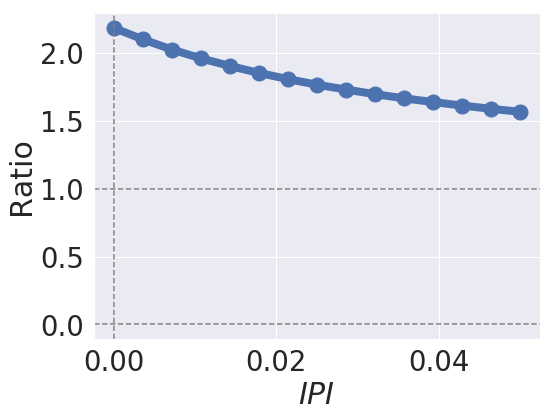

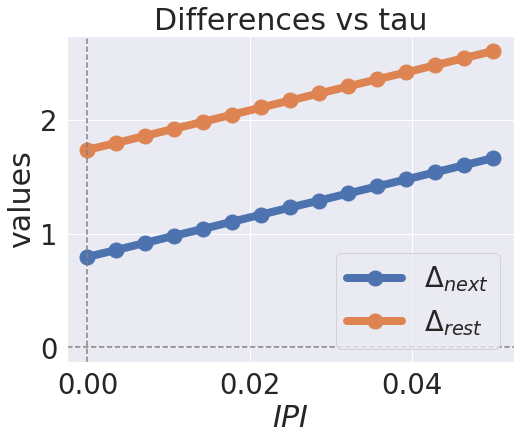

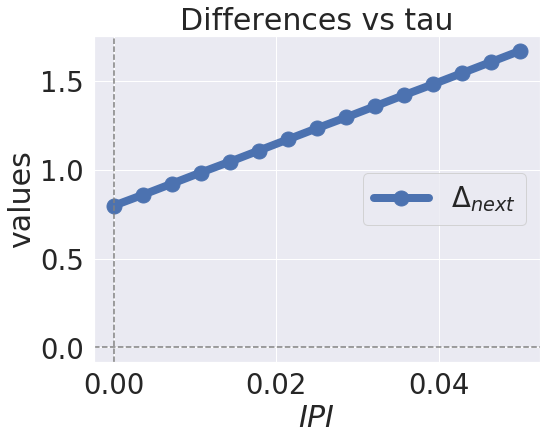

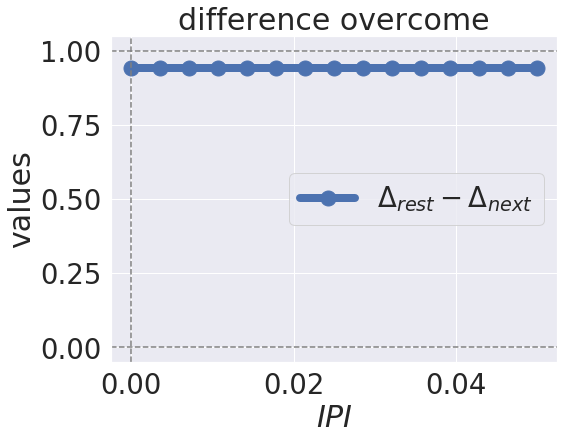

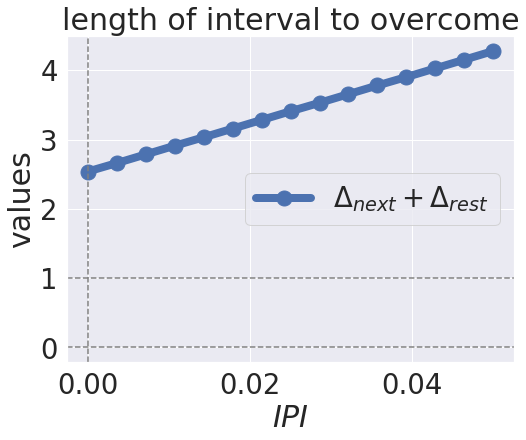

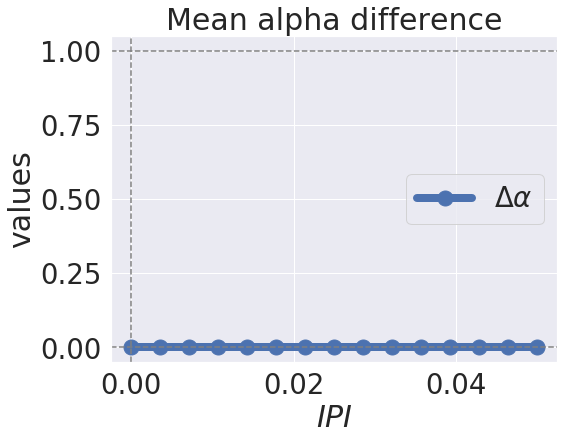

In [16]:
independent = inter_pulse_interval_vector
xlabel = r'$IPI$'

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(independent, ratios, 'o-', ms=ms, lw=lw)
ax.set_xlabel(xlabel)
ax.set_ylabel('Ratio')

ax.axhline(1, ls='--', color='gray')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray');

fig = plt.figure()
ax = fig.add_subplot(111)    

ax.plot(independent, diff_next, 'o-', ms=ms, lw=lw, label=r'$\Delta_{next}$')
ax.plot(independent, diff_rest, 'o-', ms=ms, lw=lw, label=r'$\Delta_{rest}$')
ax.set_title('Differences vs tau')
ax.set_xlabel(xlabel)
ax.set_ylabel('values')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

fig = plt.figure()
ax = fig.add_subplot(111)    

ax.plot(independent, diff_next, 'o-', ms=ms, lw=lw, label=r'$\Delta_{next}$')
ax.set_title('Differences vs tau')
ax.set_xlabel(xlabel)
ax.set_ylabel('values')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

fig = plt.figure()
ax = fig.add_subplot(111)    

ax.plot(independent, diff_rest - diff_next, 'o-', ms=ms, lw=lw, label=r'$\Delta_{rest} - \Delta_{next}$')
ax.set_title('difference overcome')
ax.set_xlabel(xlabel)
ax.set_ylabel('values')

ax.axhline(1.0, ls='--', color='gray')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

fig = plt.figure()
ax = fig.add_subplot(111)   
ax.plot(independent, diff_next + diff_rest, 'o-', ms=ms, lw=lw, label=r'$\Delta_{next} + \Delta_{rest}$ ')
ax.set_title('length of interval to overcome')
ax.set_xlabel(xlabel)
ax.set_ylabel('values')

ax.axhline(1.0, ls='--', color='gray')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend()

fig = plt.figure()
ax = fig.add_subplot(111)    

ax.plot(independent, mean_alpha_differences, 'o-', ms=ms, lw=lw, label=r'$\Delta \alpha$')
ax.set_title('Mean alpha difference')
ax.set_xlabel(xlabel)
ax.set_ylabel('values')

ax.axhline(1.0, ls='--', color='gray')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

## Is alpha constant

### An example

In [17]:
training_time = 0.100
inter_pulse_interval = 0
tau_z_pre = 0.025
tau_z_post = 0.025
results_dictionary = get_weights_structure(training_time, inter_pulse_interval, tau_z_pre, 
                                           tau_z_post, include_first=False)
index = 0
alphas = results_dictionary['alphas']
np.mean(np.diff(alphas))

-2.9605947323337506e-16

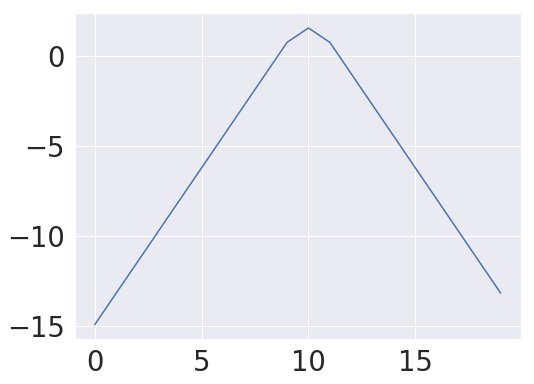

In [18]:
plt.plot(results_dictionary['w'])